# Create the CNN dataframe from "scratch"

This code tried to replicate what Pierre did in his Master Thesis to understand where the images where lost and if more could be saved. No more image could be saved, this notebook thus just shows where the patients are lost."

**FINALLY NOT USED**

## 0. Settings

In [1]:
# Libraries
%load_ext autoreload
%autoreload 2

import os
import traceback
from time import time

import pandas as pd
import numpy as np
import pickle
from ast import literal_eval

import torch

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Rectangle
import cv2

from utils_pierre import image_preprocessing

In [2]:
# Constants
PATH_TO_IMAGES = "../../Labelling_EPFL_CHUV/"
PATH_TO_SAVE_NEW_IMGS = "data/processed_imgs/"

In [3]:
# Utils functions
def get_immediate_subdirectories(a_dir):
    """
        Aim: get the list of the subdirectories, from https://stackoverflow.com/questions/800197/how-to-get-all-of-the-immediate-subdirectories-in-python
        
        Parameters:
            - a_dir: the path to the place where to look for directories
            
        Output: the list of directories
    """
    return [name for name in os.listdir(a_dir)
            if os.path.isdir(os.path.join(a_dir, name))]

In [7]:
notation_sessions = get_immediate_subdirectories(PATH_TO_IMAGES)

patient_l = []

for session in notation_sessions:
    print("Session {}".format(session))
    session_patients = get_immediate_subdirectories(os.path.join(PATH_TO_IMAGES, session))
    for patient in session_patients:
        print("Patient {}".format(patient[:11]))
        patient_l.append(patient[:11])

Session Nicolas NCL
Patient 946-269-465
Patient 925-123-012
Patient 847-468-825
Patient 848-515-352
Patient 850-435-511
Patient 856-051-656
Patient 858-420-835
Patient 859-286-780
Patient 868-687-338
Patient 868-813-203
Patient 872-185-900
Patient 872-836-987
Patient 873-715-134
Patient 875-891-330
Patient 876-190-364
Patient 878-955-464
Patient 881-701-508
Patient 884-291-320
Patient 888-369-396
Patient 891-940-855
Patient 892-141-78X
Patient 893-517-537
Patient 894-285-337
Patient 895-967-967
Patient 896-202-436
Patient 897-035-431
Patient 897-213-542
Patient 897-943-324
Patient 898-305-100
Patient 904-951-025
Patient 907-021-461
Patient 908-048-17X
Patient 909-968-288
Patient 909-972-863
Patient 920-564-992
Patient 924-021-50X
Patient 924-959-481
Patient 931-875-820
Patient 938-024-555
Patient 939-544-391
Patient 946-443-065
Patient 955-700-683
Patient 957-486-000
Patient 957-635-992
Patient 959-330-808
Patient 962-980-075
Patient 963-361-528
Patient 964-510-868
Patient 973-265-414


## 1. Create the df for images at artery level

In [4]:
# See the number of patients

import os
rootdir = '../../Labelling_EPFL_CHUV/'

notation_sessions = get_immediate_subdirectories(rootdir)
patients = []
x = 0
for session in notation_sessions:
    print(session)
    session_patients = get_immediate_subdirectories(os.path.join(rootdir, session))
    print(len(session_patients))
    x += len(session_patients)
    
    patients += session_patients
    
print("\nTotal: {}".format(x))
print("\nTotal no repet: {}".format(len(set(patients))))

Nicolas NCL
119
Farhang NCL
237
Farhang revasc only
58
Farhang MI with or without revasc
52
Farhang NCL 2
100
Farhang_grèce
60
Farhang NCL 3
47
Farhang NCL 4
24
Farhang NCL 5_low_quality
5
Farhang MI without revasc
8
Farhang MI with revasc 2nd annotation
49

Total: 759

Total no repet: 709


error is : False


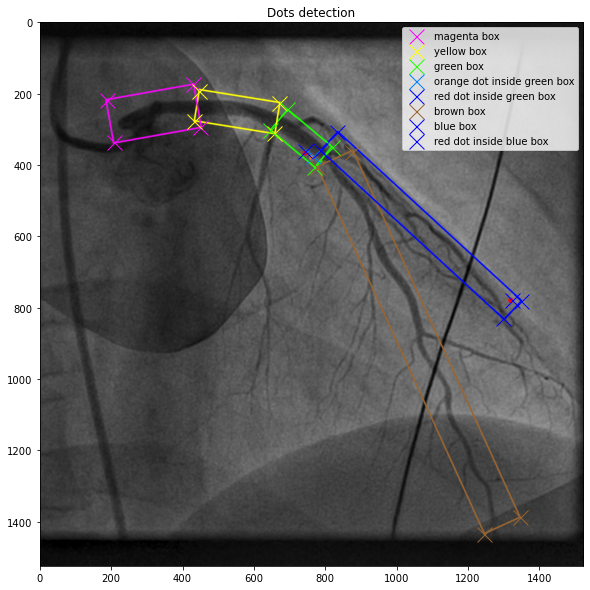

{'error': [False, False, False, False, False],
 'path_box': ['../Labelling_EPFL_CHUV/Farhang MI with revasc 2nd annotation/074-353-545_311026527_20.04.2011/LAD_1.tif',
  '../Labelling_EPFL_CHUV/Farhang MI with revasc 2nd annotation/074-353-545_311026527_20.04.2011/LAD_1.tif',
  '../Labelling_EPFL_CHUV/Farhang MI with revasc 2nd annotation/074-353-545_311026527_20.04.2011/LAD_1.tif',
  '../Labelling_EPFL_CHUV/Farhang MI with revasc 2nd annotation/074-353-545_311026527_20.04.2011/LAD_1.tif',
  '../Labelling_EPFL_CHUV/Farhang MI with revasc 2nd annotation/074-353-545_311026527_20.04.2011/LAD_1.tif'],
 'patient_box': ['074-353-545_311026527_20.04.2011',
  '074-353-545_311026527_20.04.2011',
  '074-353-545_311026527_20.04.2011',
  '074-353-545_311026527_20.04.2011',
  '074-353-545_311026527_20.04.2011'],
 'segment_box': ['LAD', 'LAD', 'LAD', 'LAD', 'LAD'],
 'view_box': ['1', '1', '1', '1', '1'],
 'color_box': ['magenta', 'yellow', 'green', 'brown', 'blue'],
 'coordinate_box': [[[336, 207], 

In [5]:
# Example of image preprocessing (function from pierre)
image_preprocessing(os.path.join(PATH_TO_IMAGES, "Farhang MI with revasc 2nd annotation", "074-353-545_311026527_20.04.2011", 
                                 "LAD_1.tif"), visualize=False, visualize_simple=True)

In [6]:
# Create a df with the information of all images

notation_sessions = get_immediate_subdirectories(PATH_TO_IMAGES)

files_dict_list = []

for session in notation_sessions:
    print("Session {}".format(session))
    session_patients = get_immediate_subdirectories(os.path.join(PATH_TO_IMAGES, session))
    for patient in session_patients:
        print("Patient {}".format(patient))
        onlyfiles = [f for f in os.listdir(os.path.join(PATH_TO_IMAGES, session, patient)) 
                     if os.path.isfile(os.path.join(PATH_TO_IMAGES, session, patient, f))]
        for file in onlyfiles:
            sep_file = x = file.split(".")
            if sep_file[-1]=="tif" and "copie" not in file and "._" not in file:
                file_path = os.path.join(PATH_TO_IMAGES, session, patient, file)
                try:
                    file_dict = image_preprocessing(file_path, visualize=False, visualize_simple=False)
                except:
                    print("Ignored file: {}".format(file_path))
                files_dict_list.append(file_dict)
                    
df = pd.DataFrame(files_dict_list)
df.to_csv("all_imgs_infos_df.csv")

Session Nicolas NCL
Not abble to find the rectangle of color magenta_dark  in image path :  ../Labelling_EPFL_CHUV/Nicolas NCL/848-515-352_311030816_09.05.2011/LAD_4.tif
Not abble to find the rectangle of color magenta_dark  in image path :  ../Labelling_EPFL_CHUV/Nicolas NCL/859-286-780_314071281_21.07.2014/LAD_1.tif
Dot found no box
Dot found no box
Not abble to find the rectangle of color magenta_dark  in image path :  ../Labelling_EPFL_CHUV/Nicolas NCL/908-048-17X_313101010_19.10.2013/LAD_1.tif
Dot found no box
Dot found no box
Not abble to find the rectangle of color magenta_dark  in image path :  ../Labelling_EPFL_CHUV/Nicolas NCL/941-796-798_312045661_10.05.2012/LAD_2.tif
Not abble to find the rectangle of color magenta_dark  in image path :  ../Labelling_EPFL_CHUV/Nicolas NCL/956-442-606_312023266_07.03.2012/LAD_1.tif
Ignored file: ../Labelling_EPFL_CHUV/Nicolas NCL/970-165-444_311086023_01.11.2011/LCX_2.tif
Not abble to find the rectangle of color magenta_dark  in image path :

Not abble to find the rectangle of color magenta_dark  in image path :  ../Labelling_EPFL_CHUV/Farhang NCL 2/485-696-983_316089009_30.08.2016/LCX_1.tif
Not abble to find the rectangle of color magenta_dark  in image path :  ../Labelling_EPFL_CHUV/Farhang NCL 2/485-696-983_316089009_30.08.2016/LAD_1.tif
Not abble to find the rectangle of color magenta_dark  in image path :  ../Labelling_EPFL_CHUV/Farhang NCL 2/503-945-955_312048149_18.05.2012/LAD_1.tif
Not abble to find the rectangle of color magenta_dark  in image path :  ../Labelling_EPFL_CHUV/Farhang NCL 2/526-528-390_311103890_26.12.2011/LAD_1.tif
Not abble to find the rectangle of color magenta_dark  in image path :  ../Labelling_EPFL_CHUV/Farhang NCL 2/531-417-349_310053122_20.08.2010/LAD_1.tif
Dot found no box
Not abble to find the rectangle of color magenta_dark  in image path :  ../Labelling_EPFL_CHUV/Farhang NCL 2/541-292-239_311087220_04.11.2011/LAD_1.tif
Not abble to find the rectangle of color magenta_dark  in image path : 

<tifffile.TiffPages @9290312> invalid offset to first page 9290312


Ignored file: ../Labelling_EPFL_CHUV/Farhang MI with revasc 2nd annotation/727-627-991_310078694_10.12.2010/LCX_2_SPIDER.tif
Dot found no box
Dot found no box


In [6]:
# Load df
df = pd.read_csv("all_imgs_infos_df.csv", index_col=0)

# Convert string from csv to lists
df["patient_box"] = df["patient_box"].apply(lambda x: literal_eval(str(x)))
df["path_box"] = df["path_box"].apply(lambda x: literal_eval(str(x)))
df["segment_box"] = df["segment_box"].apply(lambda x: literal_eval(str(x)))
df["view_box"] = df["view_box"].apply(lambda x: literal_eval(str(x)))
df["error"] = df["error"].apply(lambda x: literal_eval(str(x)))
df["color_box"] = df["color_box"].apply(lambda x: literal_eval(str(x)))
df["coordinate_box"] = df["coordinate_box"].apply(lambda x: literal_eval(str(x)))
df["categories_box"] = df["categories_box"].apply(lambda x: literal_eval(str(x)))

In [7]:
def check_red(t):
    l = [item for sublist in t for item in sublist]
    return "red" in l

In [8]:
print(len(df))
void_names_idx = df[df["patient_box"].str.len()==0].index
df = df.drop(void_names_idx)
print(len(df))

4412
4411


In [9]:
# Get patient name for each image
df.loc[:, 'patient_name'] = df["patient_box"].map(lambda x: x[0])
df['patient_name'] = df['patient_name'].str.split('_').str[0]

# Get path of each image
df['path_img'] = df["path_box"].map(lambda x: x[0])

# Get view of each image
df['view_box'] = df["view_box"].map(lambda x: x[0])

# Get artery of each image
df['segment_box'] = df["segment_box"].map(lambda x: x[0])

# Check if error in the image
df["error"] = df["error"].apply(max)

# Get all catergories and check for incident
df["categories_box"] = df["categories_box"].apply(check_red)

# Remove coumns that won't be used
df = df.drop(columns={"color_box", "patient_box", "path_box"})
df = df.rename(columns={"categories_box":"target"})

In [10]:
df.sample(5)

,error,segment_box,view_box,coordinate_box,target,patient_name,path_img
1057,True,LAD,1,"[[[214, 112], [280, 252], [174, 206], [317, 15...",False,100-834-006,../Labelling_EPFL_CHUV/Farhang NCL/100-834-006...
3649,True,LCX,1,"[[[405, 266], [519, 370], [405, 370], [519, 26...",False,788-877-536,../Labelling_EPFL_CHUV/Farhang_grèce/788-877-5...
2543,False,LCX,2,"[[[751, 799], [702, 725], [768, 679], [820, 75...",False,297-135-778,../Labelling_EPFL_CHUV/Farhang MI with or with...
3504,True,LAD,1,"[[[362, 260], [509, 106], [390, 85], [477, 283...",False,753-944-402,../Labelling_EPFL_CHUV/Farhang_grèce/753-944-4...
3526,True,LAD,2,"[[[991, 312], [871, 404], [891, 294], [970, 42...",False,721-509-744,../Labelling_EPFL_CHUV/Farhang_grèce/721-509-7...


In [11]:
print("Number of unique patients is {}.".format(len(df["patient_name"].unique())))

Number of unique patients is 706.


**Already some patients lost (709 different folders --> 3 lost in trying to extract images)**

In [12]:
print(len(df))
df_grouped =df.groupby(["patient_name","segment_box","view_box"]).max()
print(len(df_grouped))
df_grouped

4411
4111


error  \
patient_name segment_box view_box          
005-251-825  LAD         1         False   
                         2         False   
             LCX         1         False   
                         2         False   
             RCA         1          True   
...                                  ...   
998-423-142  RCA         1         False   
                         2          True   
999-003-287  LCX         1          True   
                         2         False   
             RCA         1         False   

                                                                      coordinate_box  \
patient_name segment_box view_box                                                      
005-251-825  LAD         1         [[[363, 340], [459, 168], [358, 114], [263, 28...   
                         2         [[[327, 1088], [325, 966], [404, 966], [404, 1...   
             LCX         1         [[[523, 295], [525, 435], [460, 395], [585, 33...   
                         2         [[[600, 703], [755, 628], [553, 608], [708, 53...   
             RCA         1         [[[522, 217], [636, 280], [348, 520], [464, 58...   
...                                                                              ...   
998-423-142  RCA         1         [[[298, 323], [298, 603], [424, 323], [424, 60...   
                         2         [[[86, 288], [237, 420], [140, 454], [181, 258...   
999-003-287  LCX         1         [[[141, 175], [237, 268], [96, 224], [188, 318...   
                         2         [[[532, 450], [594, 368], [649, 538], [711, 45...   
             RCA         1         [[[240, 394], [121, 358], [30, 669], [143, 703...   

                                   target  \
patient_name segment_box view_box           
005-251-825  LAD         1          False   
                         2          False   
             LCX         1          False   
                         2          False   
             RCA         1          False   
...                                   ...   
998-423-142  RCA         1          False   
                         2          False   
999-003-287  LCX         1          False   
                         2          False   
             RCA         1          False   

                                                                            path_img  
patient_name segment_box view_box                                                     
005-251-825  LAD         1         ../Labelling_EPFL_CHUV/Farhang NCL/005-251-825...  
                         2         ../Labelling_EPFL_CHUV/Farhang NCL/005-251-825...  
             LCX         1         ../Labelling_EPFL_CHUV/Farhang NCL/005-251-825...  
                         2         ../Labelling_EPFL_CHUV/Farhang NCL/005-251-825...  
             RCA         1         ../Labelling_EPFL_CHUV/Farhang NCL/005-251-825...  
...                                                                              ...  
998-423-142  RCA         1         ../Labelling_EPFL_CHUV/Nicolas NCL/998-423-142...  
                         2         ../Labelling_EPFL_CHUV/Nicolas NCL/998-423-142...  
999-003-287  LCX         1         ../Labelling_EPFL_CHUV/Nicolas NCL/999-003-287...  
                         2         ../Labelling_EPFL_CHUV/Nicolas NCL/999-003-287...  
             RCA         1         ../Labelling_EPFL_CHUV/Nicolas NCL/999-003-287...  

[4111 rows x 4 columns]

In [1]:
# Construct a patient df from the whole images df and only keep patient that have all the needed data
# --> 2 views of three arteries

patient_names = df_grouped.index.get_level_values(0).unique()
path_lad_1_l, path_lcx_1_l, path_rca_1_l = [], [], []
path_lad_2_l, path_lcx_2_l, path_rca_2_l = [], [], []
mi_lad_l, mi_lcx_l, mi_rca_l, patient_mi_l = [], [], [], []
boxes_lad_1_l, boxes_lcx_1_l, boxes_rca_1_l = [], [], []
boxes_lad_2_l, boxes_lcx_2_l, boxes_rca_2_l = [], [], []
error_l = []
patient_name_l = []

missed_mi = 0
missed_mi_patient = []
missed_mi_patient_path = []

for patient in patient_names:
    try:
        path_lad_1 = df_grouped.loc[patient,"LAD","1"]["path_img"]
        path_lad_2 = df_grouped.loc[patient,"LAD","2"]["path_img"]
        path_lcx_1 = df_grouped.loc[patient,"LCX","1"]["path_img"]
        path_lcx_2 = df_grouped.loc[patient,"LCX","2"]["path_img"]
        path_rca_1 = df_grouped.loc[patient,"RCA","1"]["path_img"]
        path_rca_2 = df_grouped.loc[patient,"RCA","2"]["path_img"]
        mi_lad = df_grouped.loc[patient,"LAD","1"]["target"] or df_grouped.loc[patient, "LAD", "2"]["target"]
        mi_lcx = df_grouped.loc[patient,"LCX","1"]["target"] or df_grouped.loc[patient, "LCX", "2"]["target"]
        mi_rca = df_grouped.loc[patient,"RCA","1"]["target"] or df_grouped.loc[patient, "RCA", "2"]["target"]
        patient_mi = mi_lad | mi_lcx | mi_lad
        boxes_lad_1 = df_grouped.loc[patient,"LAD","1"]["coordinate_box"]
        boxes_lad_2 = df_grouped.loc[patient,"LAD","2"]["coordinate_box"]
        boxes_lcx_1 = df_grouped.loc[patient,"LCX","1"]["coordinate_box"]
        boxes_lcx_2 = df_grouped.loc[patient,"LCX","2"]["coordinate_box"]
        boxes_rca_1 = df_grouped.loc[patient,"RCA","1"]["coordinate_box"]
        boxes_rca_2 = df_grouped.loc[patient,"RCA","2"]["coordinate_box"]
        error = (df_grouped.loc[patient,"LAD","1"]["error"] |
                      df_grouped.loc[patient,"LAD","2"]["error"] |
                      df_grouped.loc[patient,"LCX","1"]["error"] |
                      df_grouped.loc[patient,"LCX","2"]["error"] |
                      df_grouped.loc[patient,"RCA","1"]["error"] | df_grouped.loc[patient,"RCA","2"]["error"])

        patient_name_l.append(patient)
        path_lad_1_l.append(path_lad_1)
        path_lad_2_l.append(path_lad_2)
        path_lcx_1_l.append(path_lcx_1)
        path_lcx_2_l.append(path_lcx_2)
        path_rca_1_l.append(path_rca_1)
        path_rca_2_l.append(path_rca_2)
        mi_lad_l.append(mi_lad)
        mi_lcx_l.append(mi_lcx)
        mi_rca_l.append(mi_rca)
        patient_mi_l.append(patient_mi)
        boxes_lad_1_l.append(boxes_lad_1)
        boxes_lad_2_l.append(boxes_lad_2)
        boxes_lcx_1_l.append(boxes_lcx_1)
        boxes_lcx_2_l.append(boxes_lcx_2)
        boxes_rca_1_l.append(boxes_rca_1)
        boxes_rca_2_l.append(boxes_rca_2)
        error_l.append(error)
    except:
        print(patient, " has missing data")
        
        patient_info = df_grouped.loc[patient]
        mi = max(patient_info["target"])
        
        missed_mi += mi
        if mi:
            missed_mi_patient.append(patient)

     


df_patient = pd.DataFrame({"patient_id": patient_name_l,
                           'path_lad_1': path_lad_1_l,
                            'path_lad_2': path_lad_2_l,
                            'path_lcx_1': path_lcx_1_l,
                            'path_lcx_2': path_lcx_2_l,
                            'path_rca_1': path_rca_1_l,
                            'path_rca_2': path_rca_2_l,
                           'mi_lad': mi_lad_l,
                            'mi_lcx': mi_lcx_l,
                            'mi_rca': mi_rca_l,
                           'patient_mi': patient_mi_l,
                            'boxes_lad_1': boxes_lad_1_l,
                            'boxes_lad_2': boxes_lad_2_l,
                            'boxes_lcx_1': boxes_lcx_1_l,
                            'boxes_lcx_2': boxes_lcx_2_l,
                            'boxes_rca_1': boxes_rca_1_l,
                            'boxes_rca_2': boxes_rca_2_l,
                            'error': error_l,
})

                          
print(missed_mi)
print(missed_mi_patient)
df_patient

NameError: name 'df_grouped' is not defined

In [30]:
len(df_patient[df_patient["patient_mi"]==1])

18

In [34]:
print(len(missed_mi_patient))

24


In [34]:
df_patient.sample(3)

,patient_id,path_lad_1,path_lad_2,path_lcx_1,path_lcx_2,path_rca_1,path_rca_2,mi_lad,mi_lcx,mi_rca,patient_mi,boxes_lad_1,boxes_lad_2,boxes_lcx_1,boxes_lcx_2,boxes_rca_1,boxes_rca_2,error
181,419-882-516,../Labelling_EPFL_CHUV/Farhang NCL/419-882-516...,../Labelling_EPFL_CHUV/Farhang NCL/419-882-516...,../Labelling_EPFL_CHUV/Farhang NCL/419-882-516...,../Labelling_EPFL_CHUV/Farhang NCL/419-882-516...,../Labelling_EPFL_CHUV/Farhang NCL/419-882-516...,../Labelling_EPFL_CHUV/Farhang NCL/419-882-516...,False,False,False,False,"[[[495, 281], [583, 181], [495, 183], [581, 28...","[[[5, 386], [115, 213], [5, 215], [113, 386]],...","[[[191, 376], [302, 207], [191, 209], [300, 37...","[[[20, 389], [132, 231], [20, 233], [130, 389]...","[[[400, 521], [509, 683], [400, 683], [509, 52...","[[[432, 529], [432, 633], [523, 529], [523, 63...",True
247,553-940-163,../Labelling_EPFL_CHUV/Farhang NCL 2/553-940-1...,../Labelling_EPFL_CHUV/Farhang NCL 2/553-940-1...,../Labelling_EPFL_CHUV/Farhang NCL 2/553-940-1...,../Labelling_EPFL_CHUV/Farhang NCL 2/553-940-1...,../Labelling_EPFL_CHUV/Farhang NCL 2/553-940-1...,../Labelling_EPFL_CHUV/Farhang NCL 2/553-940-1...,False,False,False,False,"[[[317, 140], [207, 199], [225, 115], [298, 22...","[[[13, 467], [13, 514], [92, 467], [92, 514]],...","[[[249.0, 117.0], [313.0, 144.0], [216.0, 186....","[[[14, 472], [91, 522], [14, 522], [91, 472]],...","[[[317, 588], [176, 909], [195, 581], [298, 91...","[[[435, 950], [451, 448], [625, 868], [261, 53...",True
295,657-823-991,../Labelling_EPFL_CHUV/Farhang NCL 3/657-823-9...,../Labelling_EPFL_CHUV/Farhang NCL 3/657-823-9...,../Labelling_EPFL_CHUV/Farhang NCL 3/657-823-9...,../Labelling_EPFL_CHUV/Farhang NCL 3/657-823-9...,../Labelling_EPFL_CHUV/Farhang NCL 3/657-823-9...,../Labelling_EPFL_CHUV/Farhang NCL 3/657-823-9...,False,False,False,False,"[[[224, 147], [393, 122], [331, 53], [289, 216...","[[[100, 113], [32, 260], [222, 167], [158, 316...","[[[372, 365], [390, 192], [467, 265], [299, 29...","[[[629, 305], [638, 524], [735, 374], [532, 45...","[[[240, 315], [351, 585], [240, 585], [351, 31...","[[[326, 478], [433, 778], [326, 778], [433, 47...",True


**Here lost 300 patients that didn't had the three * 2 views**

In [35]:
# We want the images without the boxes
for path in ["path_lad_1", "path_lad_2", "path_lcx_1", "path_lcx_2", "path_rca_1", "path_rca_2"]:
    df_patient[path] = df_patient[path].str[:-4] + " copie.tif"
df_patient.sample(3)

,patient_id,path_lad_1,path_lad_2,path_lcx_1,path_lcx_2,path_rca_1,path_rca_2,mi_lad,mi_lcx,mi_rca,patient_mi,boxes_lad_1,boxes_lad_2,boxes_lcx_1,boxes_lcx_2,boxes_rca_1,boxes_rca_2,error
406,960-845-164,../Labelling_EPFL_CHUV/Farhang MI without reva...,../Labelling_EPFL_CHUV/Farhang MI without reva...,../Labelling_EPFL_CHUV/Farhang MI without reva...,../Labelling_EPFL_CHUV/Farhang MI without reva...,../Labelling_EPFL_CHUV/Farhang MI without reva...,../Labelling_EPFL_CHUV/Farhang MI without reva...,False,False,False,False,"[[[181, 83], [181, 168], [285, 168], [287, 81]...","[[[548, 263], [484, 193], [416, 258], [478, 32...","[[[404, 318], [258, 168], [280, 334], [383, 15...","[[[870, 785], [730, 626], [860, 620], [743, 79...","[[[167, 606], [142, 309], [34, 369], [272, 544...","[[[443, 560], [282, 374], [333, 583], [394, 34...",True
214,489-037-02X,../Labelling_EPFL_CHUV/Farhang NCL 2/489-037-0...,../Labelling_EPFL_CHUV/Farhang NCL 2/489-037-0...,../Labelling_EPFL_CHUV/Farhang NCL 2/489-037-0...,../Labelling_EPFL_CHUV/Farhang NCL 2/489-037-0...,../Labelling_EPFL_CHUV/Farhang NCL 2/489-037-0...,../Labelling_EPFL_CHUV/Farhang NCL 2/489-037-0...,False,False,False,False,"[[[201, 99], [201, 193], [308, 99], [308, 193]...","[[[91, 474], [274, 448], [173, 369], [194, 551...","[[[308, 293], [455, 338], [409, 244], [354, 38...","[[[818, 637], [995, 560], [888, 504], [924, 69...","[[[579, 662], [538, 419], [653, 619], [461, 46...","[[[355, 353], [473, 476], [355, 476], [473, 35...",True
25,067-175-957,../Labelling_EPFL_CHUV/Farhang NCL/067-175-957...,../Labelling_EPFL_CHUV/Farhang NCL/067-175-957...,../Labelling_EPFL_CHUV/Farhang NCL/067-175-957...,../Labelling_EPFL_CHUV/Farhang NCL/067-175-957...,../Labelling_EPFL_CHUV/Farhang NCL/067-175-957...,../Labelling_EPFL_CHUV/Farhang NCL/067-175-957...,False,False,False,False,"[[[345, 185], [438, 217], [378, 390], [288, 35...","[[[87, 1141], [87, 1238], [197, 1238], [199, 1...","[[[282, 366], [444, 222], [381, 399], [341, 18...","[[[645, 792], [498, 743], [561, 844], [581, 69...","[[[400, 351], [400, 482], [497, 351], [497, 48...","[[[420, 262], [442, 516], [332, 310], [531, 46...",True


In [36]:
df_patient = df_patient.set_index('patient_id')

In [37]:
df_patient.loc[np.unique(patients_to_remove)]

,path_lad_1,path_lad_2,path_lcx_1,path_lcx_2,path_rca_1,path_rca_2,mi_lad,mi_lcx,mi_rca,patient_mi,boxes_lad_1,boxes_lad_2,boxes_lcx_1,boxes_lcx_2,boxes_rca_1,boxes_rca_2,error
patient_id,,,,,,,,,,,,,,,,,
053-119-471,../Labelling_EPFL_CHUV/Farhang revasc only/053...,../Labelling_EPFL_CHUV/Farhang revasc only/053...,../Labelling_EPFL_CHUV/Farhang revasc only/053...,../Labelling_EPFL_CHUV/Farhang revasc only/053...,../Labelling_EPFL_CHUV/Farhang revasc only/053...,../Labelling_EPFL_CHUV/Farhang revasc only/053...,False,False,False,False,"[[[110, 575], [202, 327], [76, 349], [240, 554...","[[[511, 160], [671, 365], [619, 138], [566, 38...","[[[268, 85], [236, 290], [169, 130], [335, 245...","[[[93, 520], [213, 340], [93, 342], [211, 520]...","[[[509, 622], [652, 396], [546, 380], [615, 63...","[[[66, 636], [182, 874], [66, 874], [182, 636]...",True
091-321-350,../Labelling_EPFL_CHUV/Farhang NCL/091-321-350...,../Labelling_EPFL_CHUV/Farhang NCL/091-321-350...,../Labelling_EPFL_CHUV/Farhang NCL/091-321-350...,../Labelling_EPFL_CHUV/Farhang NCL/091-321-350...,../Labelling_EPFL_CHUV/Farhang NCL/091-321-350...,../Labelling_EPFL_CHUV/Farhang NCL/091-321-350...,False,False,False,False,"[[[69, 121], [69, 230], [147, 121], [147, 230]...","[[[4, 410], [111, 272], [4, 274], [109, 410]],...","[[[252, 252], [363, 378], [252, 378], [363, 25...","[[[273, 405], [156, 377], [303, 287], [188, 25...","[[[394, 751], [394, 877], [559, 751], [559, 87...","[[[152, 730], [152, 833], [307, 730], [307, 83...",True
789-075-585,../Labelling_EPFL_CHUV/Farhang revasc only/789...,../Labelling_EPFL_CHUV/Farhang revasc only/789...,../Labelling_EPFL_CHUV/Farhang revasc only/789...,../Labelling_EPFL_CHUV/Farhang revasc only/789...,../Labelling_EPFL_CHUV/Farhang revasc only/789...,../Labelling_EPFL_CHUV/Farhang revasc only/789...,False,False,False,False,"[[[426, 305], [499, 488], [529, 327], [395, 47...","[[[550, 412], [600, 262], [666, 453], [717, 29...","[[[221, 19], [221, 119], [346, 119], [348, 17]...","[[[196, 611], [400, 935], [302, 585], [296, 96...","[[[262, 424], [262, 728], [452, 424], [452, 72...","[[[416, 622], [428, 431], [341, 479], [503, 57...",True
987-729-159,../Labelling_EPFL_CHUV/Nicolas NCL/987-729-159...,../Labelling_EPFL_CHUV/Nicolas NCL/987-729-159...,../Labelling_EPFL_CHUV/Nicolas NCL/987-729-159...,../Labelling_EPFL_CHUV/Nicolas NCL/987-729-159...,../Labelling_EPFL_CHUV/Nicolas NCL/987-729-159...,../Labelling_EPFL_CHUV/Nicolas NCL/987-729-159...,False,False,False,False,"[[[497, 743], [491, 892], [568, 810], [419, 82...","[[[531, 171], [469, 62], [372, 123], [434, 231...","[[[290.0, 110.0], [198.0, 127.0], [210.0, 190....","[[[587, 415], [626, 550], [541, 467], [675, 49...","[[[257, 537], [414, 46], [532, 127], [137, 456...","[[[573, 107], [573, 1307], [1240, 107], [1240,...",True


In [17]:
# remove patients without original image

list_of_img_type = ["path_lad_1", "path_lad_2", "path_rca_1", "path_rca_2", "path_lcx_1", "path_lcx_2"]

sizes = []
patients_to_remove = []

start_time = time()
for i, (index, row) in enumerate(df_patient.iterrows()):   
    if i%50 == 0:
        curr_time = time()
        print(i, "{:.2f}".format(curr_time-start_time))
        start_time = time()
        
    for img_type in list_of_img_type:
        try:
            img_path = row[img_type]
            img = mpimg.imread(img_path)

            sizes.append(np.shape(img))
        except:
            patients_to_remove.append(index)
        

0 0.00
50 218.97
100 231.25
150 220.56
200 227.65
250 212.94
300 224.28
350 253.46
400 245.93


In [18]:
print("Nb patients before {}".format(len(df_patient)))

Nb patients before 425


In [19]:
print(len(np.unique(patients_to_remove)))

4


In [20]:
print("Nb patients after {}".format(len(df_patient)))

Nb patients after 425


In [21]:
df_patient = df_patient.drop(np.unique(patients_to_remove))
print("Nb patients after {}".format(len(df_patient)))

Nb patients after 421


----